In [1]:
import sys
import os
os.chdir('../')

import itertools as it
import numpy as np
import pandas as pd
import pylab as py
import matplotlib.pyplot as plt
from  matplotlib import rc
from matplotlib.colors import LogNorm
%matplotlib inline

from tools.tools import save,load,lprint,load_config
from tools.bar import BAR

In [2]:
from fitlab.resman import RESMAN
from fitlab.parman import PARMAN

In [13]:
!ls -lah 

total 264
drwxr-xr-x  24 davidriser  staff   816B Sep 12 14:01 .
drwxr-xr-x  22 davidriser  staff   748B Sep 12 09:30 ..
-rw-r--r--   1 davidriser  staff    72B Sep  6 09:44 .gitignore
-rw-r--r--   1 davidriser  staff     0B Aug 14 19:39 __init__.py
-rw-r--r--   1 davidriser  staff   114B Aug 23 11:09 __init__.pyc
drwxr-xr-x   5 davidriser  staff   170B Sep 10 15:32 gallery
drwxr-xr-x   8 davidriser  staff   272B Sep 12 10:59 inputs
-rwxr-xr-x   1 davidriser  staff   5.0K Sep 12 13:50 maxlike.py
-rw-r--r--   1 davidriser  staff   5.8K Sep 12 13:50 maxlike.pyc
-rwxr-xr-x   1 davidriser  staff   5.0K Sep 10 15:32 maxlike.py~
-rwxr-xr-x   1 davidriser  staff   3.3K Sep 12 09:30 mcsamp.py
-rw-r--r--   1 davidriser  staff   4.9K Sep 12 09:31 mcsamp.pyc
-rwxr-xr-x   1 davidriser  staff   7.1K Sep  7 13:37 nest.py
-rw-r--r--   1 davidriser  staff    11K Sep  7 14:13 nest.pyc
drwxr-xr-x   9 davidriser  staff   306B Sep 12 13:46 notebooks
drwxr-xr-x   4 davidriser  staff   136B Sep 12 09:30 out

In [6]:
conf=load_config('runs/boermulders/boermulders.py')
conf['resman']=RESMAN(conf)
conf['resman'].get_residuals(conf['parman'].par);

KeyError: 'k+ sb N'

In [26]:
def get_binned_axis(dataframe, axis):
    return np.unique(dataframe[axis])

def create_rounded_variables(dataframe):
    dataframe['rounded_z']  = np.round(dataframe['z'], 1)
    dataframe['rounded_q2'] = np.round(dataframe['Q2'], 1)

In [9]:
datasets = {}

for index, data in conf['resman'].sidisres.tabs.iteritems():
    datasets[index] = pd.DataFrame(data) 
    create_rounded_variables(datasets[index])

In [10]:
datasets[5000].head()

,Ebeam,N,Q2,Shift,alpha,col,hadron,i,obs,pT,...,stat_u,sys_u,target,thy,value,x,y,z,rounded_z,rounded_q2
0,27.6,1.0,1.912767,0.0,0.177512,HERMES,k-,76,AUUcos2,0.27313,...,0.17723,0.01001,proton,-0.000667,-0.18545,0.05691,0.64913,0.27277,0.3,1.9
1,27.6,1.0,1.908372,0.0,0.099503,HERMES,k-,77,AUUcos2,0.41725,...,0.09851,0.01402,proton,-0.002253,-0.13131,0.05676,0.64935,0.27923,0.3,1.9
2,27.6,1.0,1.911200,0.0,0.135252,HERMES,k-,78,AUUcos2,0.57317,...,0.13436,0.01551,proton,-0.007321,0.06936,0.05664,0.65169,0.28734,0.3,1.9
3,27.6,1.0,1.911789,0.0,0.135386,HERMES,k-,80,AUUcos2,0.27715,...,0.13458,0.01475,proton,-0.001101,0.01208,0.05701,0.64766,0.34527,0.3,1.9
4,27.6,1.0,1.913151,0.0,0.092191,HERMES,k-,81,AUUcos2,0.42251,...,0.09129,0.01286,proton,-0.003439,-0.08762,0.05707,0.64744,0.34547,0.3,1.9


In [27]:
def plot_data_new(data):
    
    # get binned axes for plotting 
    bins_z = get_binned_axis(data, 'rounded_z')
    bins_q2 = get_binned_axis(data, 'rounded_q2')

    # setup canvas 
    cols = 3
    rows = np.ceil(len(bins_q2)/cols)
    plt.figure(figsize=(12,rows*6))
    
    for index in range(len(bins_q2)-1):
        plt.subplot(rows*cols, cols, index+1)
        
        # setup cuts for picking the data of interst 
        cuts = {}
        cuts['rounded_q2'] = ('rounded_q2 > %f and rounded_q2 < %f' % (bins_q2[index], bins_q2[index+1]))
        
        # get each z-bin of data and plot it 
        for index_z in range(len(bins_z)-1):
            cuts['rounded_z'] = ('rounded_z > %f and rounded_z < %f' % (bins_z[index_z], bins_z[index_z+1]))
            data_subset = data.query(cuts['rounded_q2'] + ' and ' + cuts['rounded_z'])
        
            print 'data_subset has entries = ', len(data_subset)
            plt.errorbar(data_subset.pT, data_subset.value, data_subset.alpha)
    
    plt.tight_layout()

In [36]:
def plot_data(tab):
    Q2=sorted(set(tab.rounded_q2))

    ncols=4
    nrows=len(Q2)/ncols
    if len(Q2)%ncols!=0: nrows+=1
    py.figure(figsize=(ncols*5,nrows*5))
    for i in range(len(Q2)):
        d1=tab.query('rounded_q2 == %f'%Q2[i])
        
        ax=py.subplot(nrows,ncols,i+1)
        rz=sorted(set(d1.rounded_z))
        rz=[[0.2, 0.3], 
            [0.301, 0.4], 
            [0.401, 0.5],
            [0.501, 0.6]]
        
        cnt=0
        for _rz in rz:
            #d2=d1.query('rz==%f'%_rz)
            d2=d1.query('rounded_z >%f and rounded_z <%f'%(_rz[0],_rz[1]))
            I=np.argsort(d2.pT.values)
            scale=4**cnt
            cnt+=1

            if len(d2.x.values) is not 0:
                p=ax.errorbar(d2.pT,d2.value*scale,d2.alpha*scale,fmt='.',label='z=[%0.2f,%0.2f]'%(_rz[0],_rz[1]))
#            p=ax.errorbar(d2.pT,d2.value*scale,d2.alpha*scale,fmt='.')
                if len(d2.index)>1:
                    ax.plot(d2.pT.values[I],d2.thy.values[I]*scale,color=p[0].get_color())
                else:
                    ax.plot(d2.pT.values[I],d2.thy.values[I]*scale,color=p[0].get_color(),marker='x')
                    if i==0: ax.set_ylabel('M(HERMES)x4^i',size=20)
                    ax.set_xlabel('$p_T$',size=20)
                    ax.set_title('Q2=%0.2f  x=%0.2f'%(Q2[i],d2.x.values[0]),size=20)
                #ax.set_ylim(0.01,20)
#                ax.semilogy(nonposy='clip')
                    ax.semilogy()


#            msg='%s(%d)'%(d2.hadron.values[0],kk)
#            ax.text(0.1,0.1,msg,size=20,transform=ax.transAxes)

                ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

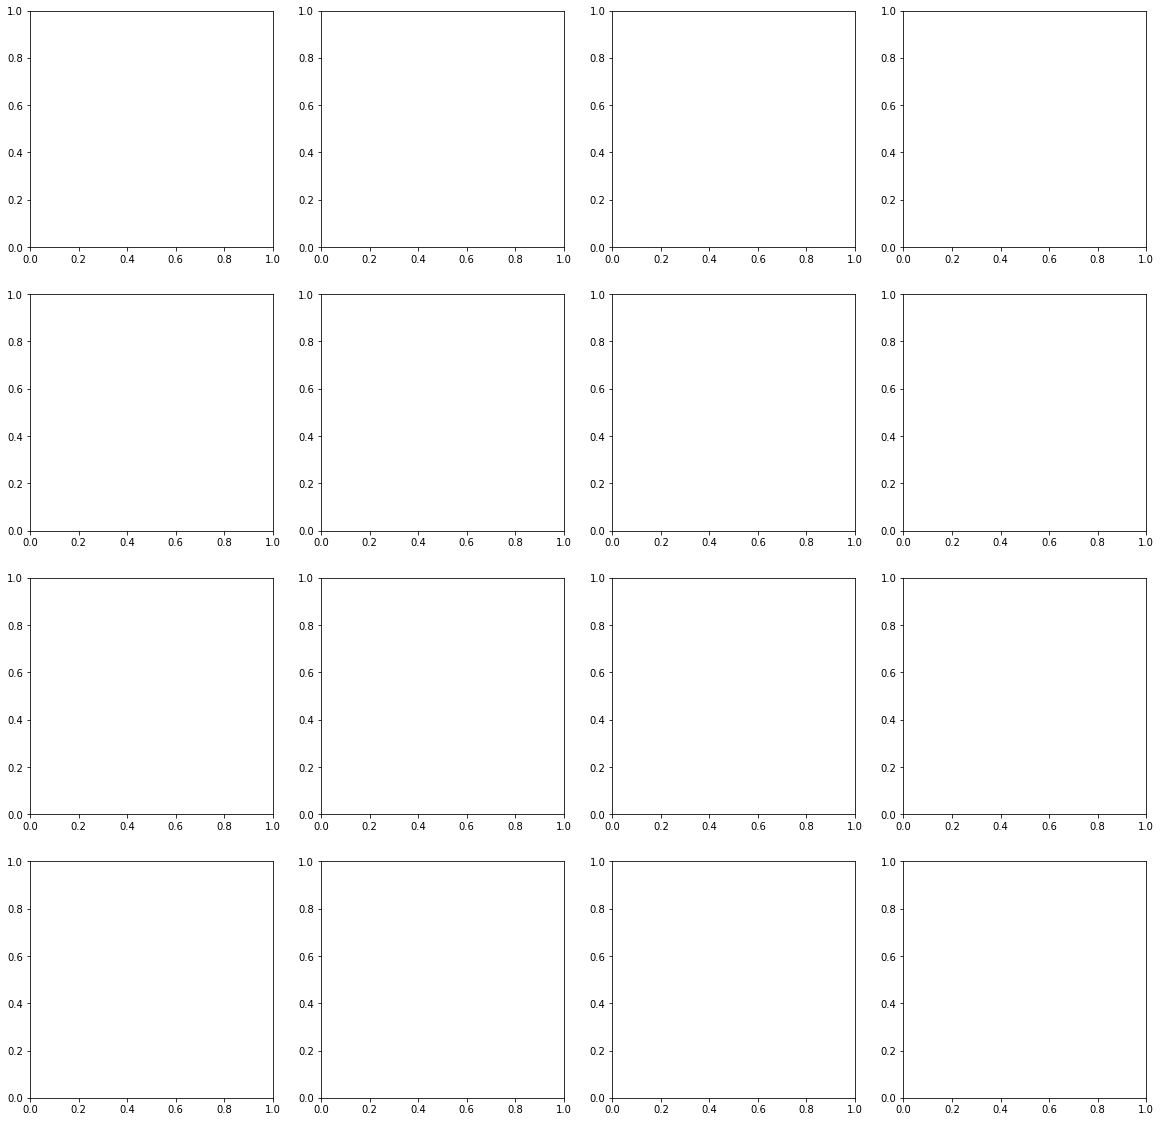

In [64]:
plot_data(datasets[5008])

data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0
data_subset has entries =  0


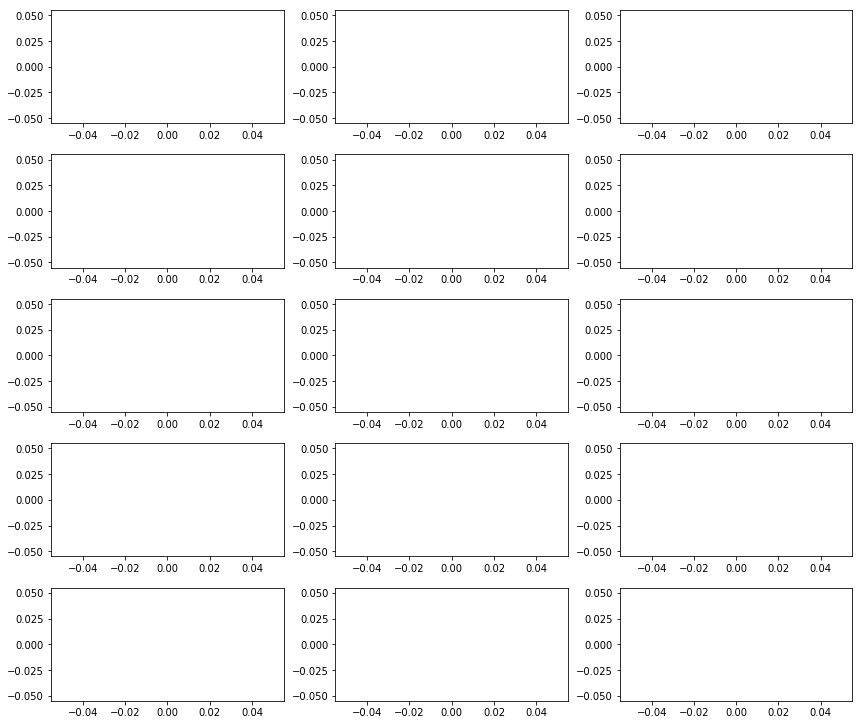

In [28]:
plot_data_new(datasets[5000])

In [33]:
print get_binned_axis(datasets[5000], 'rounded_q2')
print get_binned_axis(datasets[5000], 'rounded_z')

[ 1.9  2.   2.1  2.3  2.8  3.5  3.6  3.7  3.8  4.2  5.1  5.2  6.4  6.5  9.3
  9.4]
[ 0.3  0.4  0.5]
